#### hasznos linkek: 
1) topic reduction: https://maartengr.github.io/BERTopic/getting_started/topicreduction/topicreduction.html
2) Időbeli változáshoz vizu: https://maartengr.github.io/BERTopic/api/plotting/dtm.html

## Data preparation

### Minden egyes dialógust beolvasunk és soronként szétszedünk. 1 sor = 1 beszédforduló. A beszélgető partnerek felváltva beszélnek. Két dokumentumot készítünk. A "docs" tartalmazza az összes mordor és gondor beszédfordulót, ebben a sorrendben. A "meta" tartalmazza a "docs" metaadatait: adott beszédforduló melyik file-ból származik, ki mondta (mordor vagy gondor) és hanyadik sor.

In [1]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

import os
directory = "../data/combined_transcripts_freeConv"

docs = []
meta = {}
i = 0
for filename in os.listdir(directory):
    with open(os.path.join(directory, filename), 'r', encoding="UTF-8") as f:
        txt = f.read()

    mordor = [e.strip() for e in txt.split("\n") if e.startswith("Mordor: ")]
    gondor = [e.strip() for e in txt.split("\n") if e.startswith("Gondor: ")]

    j = len(mordor)
    k = len(gondor)
    for h in range(j):
        meta[i+h] = filename + "_mordor_" + str(h)
    for g in range(k):
        meta[i+g+j] = filename + "_gondor_" + str(g)
    mordor = [e.replace("Mordor: ", "") for e in mordor]
    gondor = [e.replace("Gondor: ", "") for e in gondor]

    docs += mordor + gondor
    a = (j+k)
    i += a
print("Az adatbázis",len(docs), "beszédfordulót tartalmaz.") 
print("Az adatbázis első beszédfordulójának metaadata:", meta[0])

Az adatbázis 23604 beszédfordulót tartalmaz.
Az adatbázis első beszédfordulójának metaadata: pair81_freeConv_combined_srt_files.txt_mordor_0


## Topic modelling

### Elkészítjük a BERT topic modellt. Többféle modellt kipróbálunk: HDBSCAN-t és KeyBERTInspired + MaximalMarginalRelevance-t.

#### 1) HDBSCAN

#### Kísérletezünk a minimális klaszter méret beállítással. A cluster number változónál adhatjuk meg, hogy mennyit szeretnénk. Minél nagyobb a szám, annál kevesebb topikot kapunk.

In [ ]:
from hdbscan import HDBSCAN
cluster_number = 500
hdbscan_model = HDBSCAN(min_cluster_size=cluster_number, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model_HDBSCAN = BERTopic("hungarian", representation_model= hdbscan_model)
topics, probs = topic_model_HDBSCAN.fit_transform(docs)

#### 2) KeyBERTInspired + MaximalMarginalRelevance

In [5]:
key = KeyBERTInspired()
mm =  MaximalMarginalRelevance(diversity=0.3)
topic_model_key_mm = BERTopic("hungarian", representation_model=[key, mm])
topics, probs = topic_model_key_mm.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Serialization and saving the models

### Lementjük az elkészített modelleket. Az azonosíthatóság kedvéért az elmentett file tartalmazza a modell nevét, az időpontot, amikor készítettük és HDBSCAN esetét a minimim klaszter nagyságot. A modell lementésére azért van szükség, mert a BERT minden futtatásnál újat készít. Az eredmény akkor értékelhető és megismételhető, ha egy adott modellel dolgozunk.

In [22]:
import datetime
now = datetime.datetime.now()
model_path_HDBSCAN = f"../data/my_model_HDBSCAN_{cluster_number}_{now}"
model_path_mixed = f"../data/my_model_key_mm_{now}"
topic_model_HDBSCAN.save(model_path_HDBSCAN, serialization="pickle")
topic_model_key_mm.save(model_path_mixed, serialization="pickle")
print("A topic modelleket elmentettük")

2024-05-09 15:47:33,738 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


A topic modelleket elmentettük


## Topics

### Visszatöltjük a kívánt topic modellt. Belenézünk a topikokba, majd lementjük őket egy csv-be.

#### 1) KeyBERTInspired + MaximalMarginalRelevance

In [9]:
loaded_model_path_key_mm = "../data/my_model_key_mm_2024-05-09 14:55:19.291314"
loaded_model_key_mm = BERTopic.load(loaded_model_path_key_mm)
print("A modellt betöltöttük")

A modellt betöltöttük


In [10]:
topic_info_key_mm = loaded_model_key_mm.get_topic_info()
topic_info_key_mm

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7047,-1_ugye_tényleg_egyébként_úgyhogy,"[ugye, tényleg, egyébként, úgyhogy, igazából, ...","[Ja és akkor úgy., De most már így. <laugh> Am..."
1,0,1869,0_hum_de__,"[hum, de, , , , , , , , ]","[<hum>, <hum>, <hum>]"
2,1,732,1_laugh___,"[laugh, , , , , , , , , ]","[<laugh>, <laugh>, <laugh>]"
3,2,527,2_ah_aha__,"[ah, aha, , , , , , , , ]","[Aha., Aha., Aha.]"
4,3,428,3_igen_ja_amúgy_hogy,"[igen, ja, amúgy, hogy, je, , , , , ]","[Igen., Igen., Igen.]"
...,...,...,...,...,...
329,328,10,328_mondtam_igen_vagyok_ja,"[mondtam, igen, vagyok, ja, egyébként, így, az...","[Igen az, azért, azért mondtam azt., Azzal én ..."
330,329,10,329_csapatnyi_csapatból_csapatban_csapatnak,"[csapatnyi, csapatból, csapatban, csapatnak, c...","[Azt már elbuktuk, hát tényleg a jobb csapat n..."
331,330,10,330_mindenhol_ott_minden_egész,"[mindenhol, ott, minden, egész, végignézem, he...","[<hum> Hát, akkor lehet mindenhol., Mindenhol ..."
332,331,10,331_amerikával_amerikába_amerikai_amerika,"[amerikával, amerikába, amerikai, amerika, háb...","[Hát ja, meg egyébként, ugye, ugyanezt csináln..."


In [11]:
print("Összesen", len(topic_info_key_mm), "darab topikot találtunk.")

Összesen 334 darab topikot találtunk.


In [6]:
print("Az általunk választott tetszőleges topik az alábbi szavakat tartalmazza:")
loaded_model_key_mm.get_topic(124)

Az általunk választott tetszőleges topik az alábbi szavakat tartalmazza:


[('aludtam', 0.731223),
 ('alszom', 0.72359246),
 ('aludt', 0.69420284),
 ('aludnom', 0.69148207),
 ('lefeküdtem', 0.6852708),
 ('aludni', 0.6762545),
 ('alszik', 0.66448534),
 ('alvás', 0.65971744),
 ('alszunk', 0.641767),
 ('elaludni', 0.6356694)]

In [9]:
import datetime
now = datetime.datetime.now()
topics_path_key_mm = f"../data/topic_info_key_mm{now}.tsv"
topic_info_key_mm.to_csv(topics_path_key_mm, sep="\t", index=False)
print("A topikokat lementettük")

A topikokat lementettük


## 2) HDBSCAN

In [3]:
loaded_model_path_HDBSCAN = "../data/my_model_HDBSCAN_1000_2024-05-09 16:37:51.805418"
loaded_model_HDBSCAN = BERTopic.load(loaded_model_path_HDBSCAN)
print("A modellt betöltöttük")

A modellt betöltöttük


In [4]:
topic_info_HDBSCAN= loaded_model_HDBSCAN.get_topic_info()
topic_info_HDBSCAN

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7002,-1_hogy_nem_így_akkor,"[hogy, nem, így, akkor, de, egy, meg, és, volt...","[<laugh> Hát, nem. Tehát, hogy. <laugh>, Jó. <..."
1,0,1869,0_hum_babák_minél_plusz,"[hum, babák, minél, plusz, nagyobb, de, , , , ]","[<hum>, <hum>, <hum>]"
2,1,733,1_laugh_állampolgárság_kettős_,"[laugh, állampolgárság, kettős, , , , , , , ]","[<laugh>, <laugh>, <laugh>]"
3,2,527,2_aha_ah_na_,"[aha, ah, na, , , , , , , ]","[Aha., Aha., Aha.]"
4,3,437,3_te_voltál_hova_hol,"[te, voltál, hova, hol, jársz, neked, jártál, ...","[És te? <laugh>, Ja, és te?, És te mi voltál?]"
...,...,...,...,...,...
329,328,10,328_covid_félbeszakított_érződött_bulin,"[covid, félbeszakított, érződött, bulin, corvi...","[Ja, a Covid idő., Csak pont a Covid., Nekünk ..."
330,329,10,329_tinderen_tinder_valahogy_társkeresők,"[tinderen, tinder, valahogy, társkeresők, akár...","[<laugh> Szóval így, a Tindert egyáltalán nem ..."
331,330,10,330_krém_végigmegy_beleesett_ordít,"[krém, végigmegy, beleesett, ordít, pofonok, í...","[Hú. Fú. Hát. Ízlések és pofonok., aki folyama..."
332,331,10,331_filmeket_nyelvtani_angolul_nézni,"[filmeket, nyelvtani, angolul, nézni, sorozato...","[És ó, egyébként filmeket nagyon sokat néztem ..."


In [7]:
print("Összesen", len(topic_info_HDBSCAN), "darab topikot találtunk.")

Összesen 334 darab topikot találtunk.


In [6]:
print("Az általunk választott tetszőleges topik az alábbi szavakat tartalmazza:")
loaded_model_HDBSCAN.get_topic(100)

Az általunk választott tetszőleges topik az alábbi szavakat tartalmazza:


[('félek', 0.04673400982436549),
 ('féltem', 0.038009353719148625),
 ('félnék', 0.030901130854496358),
 ('megijedtem', 0.030901130854496358),
 ('ijesztő', 0.02818795756025016),
 ('félsz', 0.024192063605942806),
 ('megijed', 0.0182367527854121),
 ('labdától', 0.0182367527854121),
 ('űrtől', 0.0182367527854121),
 ('tőle', 0.018048211650854448)]

#### A HDBSCAN min_cluster_size paraméterét változtatva a következőt találtuk:
- ha 100-ra állítottuk: 319 topikot kaptunk
- ha 500-ra: 322-t.
- ha 1000-re: 334-et.
Tehát esetünkben a minimum cluster size paraméter állítása nem segít a topikok számának csökkentésébe.

## Document topics 

### Minden egyes beszédfordulóra megnézhatjük a topik ajánlásokat.

In [121]:
print("A beszédfordulók legvalószínűbb topikjai:")
loaded_model_HDBSCAN.get_document_info(docs)

A beszédfordulók legvalószínűbb topikjai:


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Jó. Jó is.,266,266_jó_igen_helyes_ja,"[jó, igen, helyes, ja, hát, nagyon, hallasz, ,...","[Ja, jó., Ja, ja, ja, ja. Igen. Okos, okos nag...",jó - igen - helyes - ja - hát - nagyon - halla...,1.000000,False
1,Okés. Hallasz engem?,237,237_hallasz_hallottál_vagy_hallak,"[hallasz, hallottál, vagy, hallak, engem, okés...","[Hallasz?, Hallasz?, Hallasz?]",hallasz - hallottál - vagy - hallak - engem - ...,1.000000,False
2,"Hát, figyelj, én elolvasgattam, rád bízom. Hát...",6,6_elolvassam_olvasom_elolvasom_olvasgattam,"[elolvassam, olvasom, elolvasom, olvasgattam, ...","[Hát, igen. De én, én úgy vagyok vele, hogyha ...",elolvassam - olvasom - elolvasom - olvasgattam...,1.000000,False
3,"Hallottam fél füllel, elkaptam egy beszélgetés...",4,4_mentél_jártál_voltál_nektek,"[mentél, jártál, voltál, nektek, benned, szokt...","[és te hova jársz?, Hol voltál?, Te hova jársz...",mentél - jártál - voltál - nektek - benned - s...,1.000000,False
4,"Aha, de lehet akkor nem te, te mondtad, csak.",-1,-1_egyébként_szerintem_ugye_igazából,"[egyébként, szerintem, ugye, igazából, úgyhogy...","[Hát igen. De amúgy jó lenne nagyon, azért att...",egyébként - szerintem - ugye - igazából - úgyh...,0.000000,False
...,...,...,...,...,...,...,...,...
23599,Jajj!,182,182_huh_juj_hűha_uh,"[huh, juj, hűha, uh, jaj, hu, hú, , , ]","[Uh!, Húha!, Húha!]",huh - juj - hűha - uh - jaj - hu - hú - - -,0.896521,False
23600,Jaj.,253,253_úh_mára_okés_jaj,"[úh, mára, okés, jaj, hum, hú, , , , ]","[Jaj., Jaj., Jaj.]",úh - mára - okés - jaj - hum - hú - - - -,1.000000,True
23601,<hes> Szinkronnal szoktátok nézni?,157,157_sárkányok_sárkányt_dragonst_sárkány,"[sárkányok, sárkányt, dragonst, sárkány, sárká...","[Ja, hát, még most jött ki sorozat. Ja, az nem...",sárkányok - sárkányt - dragonst - sárkány - sá...,0.872608,False
23602,Aha.,2,2_ah_aha__,"[ah, aha, , , , , , , , ]","[Aha., Aha., Aha.]",ah - aha - - - - - - - -,1.000000,True


Egy tetszőlegesen választott beszédforduló és a beszédforduló topikjainak eloszlása:
A beszédforduló: Okés. Hallasz engem?


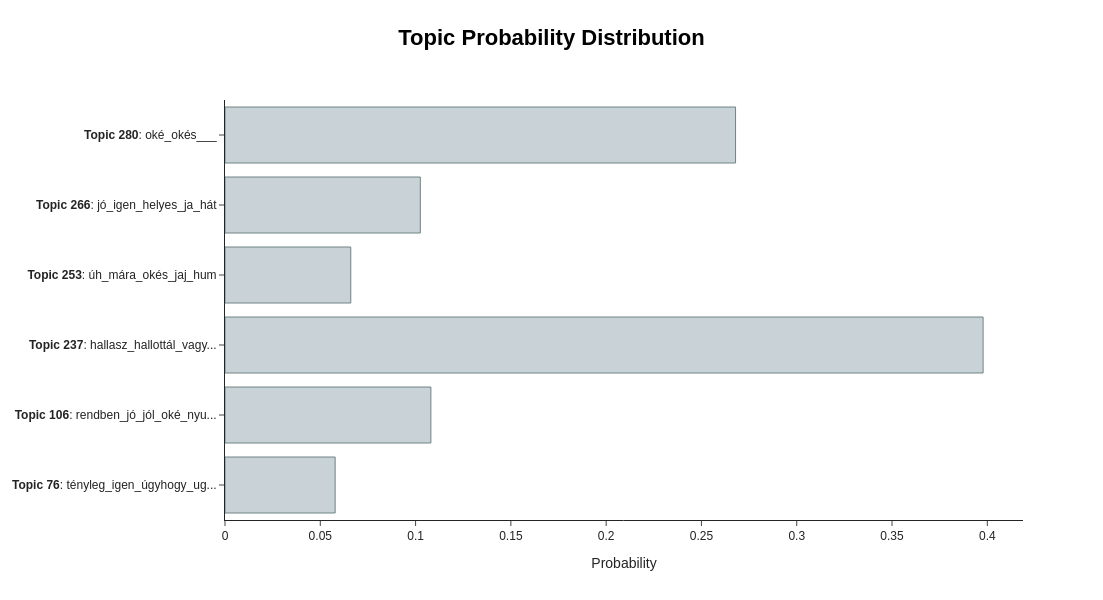

In [122]:
print("Egy tetszőlegesen választott beszédforduló és a beszédforduló topikjainak eloszlása:")
print("A beszédforduló:", docs[1])
topic_distr, xyz = loaded_model_HDBSCAN.approximate_distribution(docs)
loaded_model_HDBSCAN.visualize_distribution(topic_distr[1])

## Hierarchical topics

### Soknak tartjuk a topikok számát, ezért szeretnénk összevonni őket. Az összevonás eldöntésében segít, ha látjuk a témák hierarciáját.

100%|██████████| 332/332 [04:41<00:00,  1.18it/s]


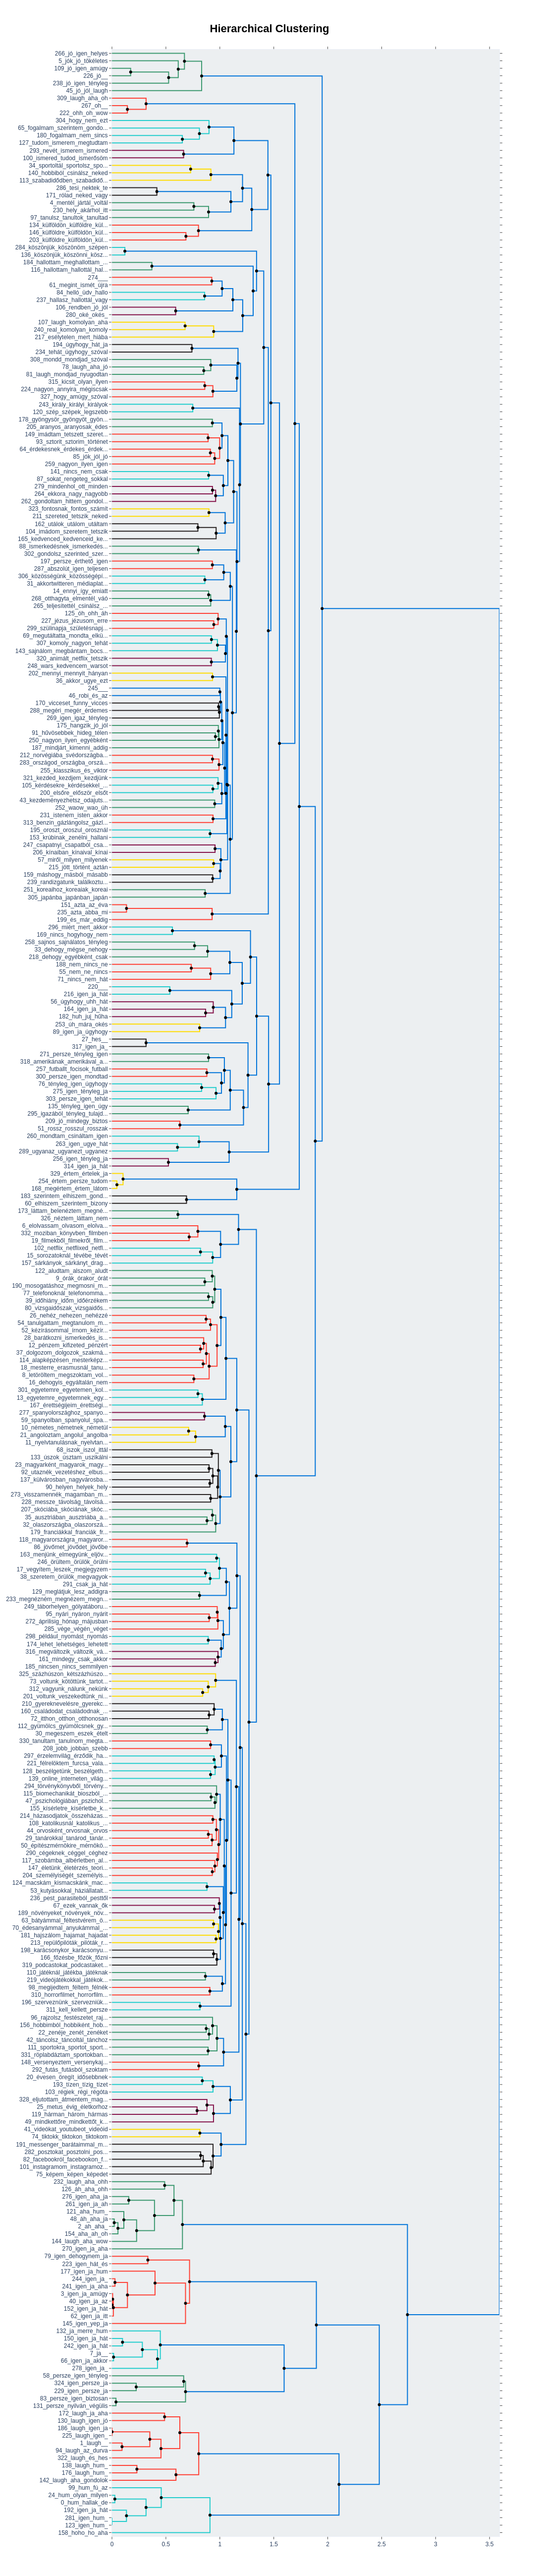

In [123]:
# Extract hierarchical topics and their representations
hierarchical_topics = loaded_model_HDBSCAN.hierarchical_topics(docs)

# Visualize these representations
loaded_model_HDBSCAN.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [135]:
fig = loaded_model_HDBSCAN.visualize_hierarchy()
fig_path = f"../data/hierarchy_{now}.html"
fig.write_html(fig_path)

## Topic reduction

### Különböző módszerekkel összevonjuk a hasonló témákat.
1) A modell futtatása előtt megadjuk a kívánt topikszámot
2) A modell futtatása előtt automatikusan összevonunk topikokat
3) A modell futtatása után megadjuk a kívánt topikszámot
4) A modell futtatása után manuálisan megadjuk hogy mely topikokat mely topi(kok)kal szeretnénk összevonni

### 1) A modell futtatása előtt megadjuk a kívánt topikszámot

In [ ]:
from bertopic import BERTopic
key = KeyBERTInspired()
mm =  MaximalMarginalRelevance(diversity=0.3)
topic_model_manual_number = BERTopic("hungarian", representation_model=[key, mm], nr_topics = 20)
topics, probs = topic_model_manual_number.fit_transform(docs)


KeyboardInterrupt



In [2]:
topic_info_manual_number = topic_model_manual_number.get_topic_info()
topic_info_manual_number

NameError: name 'topic_model_manual_number' is not defined

### 2) A modell futtatása előtt automatikusan összevonunk topikokat 

In [ ]:
from bertopic import BERTopic
key = KeyBERTInspired()
mm =  MaximalMarginalRelevance(diversity=0.3)
topic_model_auto = BERTopic("hungarian", representation_model=[key, mm], nr_topics = "auto")
topics, probs = topic_model_auto.fit_transform(docs)

### 3) A modell futtatása után megadjuk a kívánt topikszámot

In [4]:
loaded_model_path_key_mm = "../data/my_model_key_mm_2024-05-09 14:55:19.291314"
loaded_model_key_mm = BERTopic.load(loaded_model_path_key_mm)
new_model = loaded_model_key_mm.reduce_topics(docs, nr_topics=50)
topics = new_model.topics_

In [59]:
import datetime
now = datetime.datetime.now()
model_path_new = f"../data/my_model_new_{now}"
new_model.save(model_path_new, serialization="pickle")
print("A topic modellt elmentettük")

2024-05-16 17:03:12,227 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


A topic modellt elmentettük


In [9]:
topic_info_new = new_model.get_topic_info()
topic_info_new

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7047,-1_egyébként_ugye_csak_tényleg,"[egyébként, ugye, csak, tényleg, úgyhogy, hane...","[Ja és akkor úgy., <laugh> Na olyan még nekem ..."
1,0,8494,0_laugh_vicces_aha_áh,"[laugh, vicces, aha, áh, ohh, ha, ah, hum, hú,...","[<hum> <hum> <laugh>, Aha. <laugh>. <hum>., <h..."
2,1,713,1_németül_nyelvtanulás_németet_német,"[németül, nyelvtanulás, németet, német, németb...","[<laugh> <laugh> Ja, elhiszem, fú, meg még amú..."
3,2,666,2_magyarországon_magyar_magyarul_magyarország,"[magyarországon, magyar, magyarul, magyarorszá...","[Ja igen, hát azt beszéltük ugye, hogy de egyé..."
4,3,589,3_nem_dehogy_nincs_ne,"[nem, dehogy, nincs, ne, nincsen, egyáltalán, ...","[Nem, nem, nem., Nem., Nem.]"
5,4,490,4_egyetemre_egyetemnek_egyetemen_egyetemet,"[egyetemre, egyetemnek, egyetemen, egyetemet, ...","[Úgyhogy ja, az tök jó volt, ezt nagyon szeret..."
6,5,481,5_neked_vagytok_ti_szereted,"[neked, vagytok, ti, szereted, csinálod, szeri...","[És te?, És te?, És te?]"
7,6,362,6_elkezdtem_éreztem_voltam_abbahagytam,"[elkezdtem, éreztem, voltam, abbahagytam, juto...","[de én nem tudom, nekem ez a futás, ez mindig ..."
8,7,360,7_év_hónap_héten_megyek,"[év, hónap, héten, megyek, amikor, órát, időm,...","[Hát igen, szóval hogy azért mégse két és fél ..."
9,8,337,8_olvasom_elolvasom_olvasok_olvastam,"[olvasom, elolvasom, olvasok, olvastam, elolva...","[Mert amúgy nagyon szeretek olvasni, de., Meg,..."


In [12]:
import datetime
now = datetime.datetime.now()
topics_path_new = f"../data/topic_info_new_{now}.tsv"
topic_info_new.to_csv(topics_path_new, sep="\t", index=False)
print("A topikokat lementettük")

A topikokat lementettük


### 4. A modell futtatása után manuálisan megadjuk hogy mely topikokat mely topi(kok)kal akarjuk összevonni

### Nevezzük el a topikokat

In [60]:
loaded_model_path_new = "../data/my_model_new_2024-05-16 13:28:07.520018"
loaded_model_new = BERTopic.load(loaded_model_path_new)
print("A modellt betöltöttük")


A modellt betöltöttük


UnboundLocalError: local variable 'custom_labels' referenced before assignment

In [68]:
topic_labels = new_model.generate_topic_labels(nr_words=4,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")
loaded_model_new.set_topic_labels(topic_labels)

In [73]:
loaded_model_new.set_topic_labels({-1: "outliers", 2: "magyarország, külföld", 9: "hely, lakni", 22: "szabadidő, hobbi", 41: "mosás, takarítás", })

In [76]:
import datetime
now = datetime.datetime.now()
model_path_final = f"../data/my_model_final_{now}"
loaded_model_new.save(model_path_final, serialization="pickle")
print("A topic modellt elmentettük")

2024-05-16 17:36:03,092 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


A topic modellt elmentettük


In [2]:
model_path = "../data/my_model_final_2024-05-16 17:36:03.092034"
final_model = BERTopic.load(model_path)
print("A modellt betöltöttük")

A modellt betöltöttük


In [8]:
final_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,7047,-1_egyébként_ugye_csak_tényleg,outliers,"[egyébként, ugye, csak, tényleg, úgyhogy, hane...","[Ja és akkor úgy., <laugh> Na olyan még nekem ..."
1,0,8494,0_laugh_vicces_aha_áh,"laugh, vicces, aha, áh","[laugh, vicces, aha, áh, ohh, ha, ah, hum, hú,...","[<hum> <hum> <laugh>, Aha. <laugh>. <hum>., <h..."
2,1,713,1_németül_nyelvtanulás_németet_német,"németül, nyelvtanul, németet, német","[németül, nyelvtanulás, németet, német, németb...","[<laugh> <laugh> Ja, elhiszem, fú, meg még amú..."
3,2,666,2_magyarországon_magyar_magyarul_magyarország,"magyarország, külföld","[magyarországon, magyar, magyarul, magyarorszá...","[Ja igen, hát azt beszéltük ugye, hogy de egyé..."
4,3,589,3_nem_dehogy_nincs_ne,"nem, dehogy, nincs, ne","[nem, dehogy, nincs, ne, nincsen, egyáltalán, ...","[Nem, nem, nem., Nem., Nem.]"
5,4,490,4_egyetemre_egyetemnek_egyetemen_egyetemet,"egyetemre, egyetemnek, egyetemen, egyetemet","[egyetemre, egyetemnek, egyetemen, egyetemet, ...","[Úgyhogy ja, az tök jó volt, ezt nagyon szeret..."
6,5,481,5_neked_vagytok_ti_szereted,"neked, vagytok, ti, szereted","[neked, vagytok, ti, szereted, csinálod, szeri...","[És te?, És te?, És te?]"
7,6,362,6_elkezdtem_éreztem_voltam_abbahagytam,"elkezdtem, éreztem, voltam, abbahagyta","[elkezdtem, éreztem, voltam, abbahagytam, juto...","[de én nem tudom, nekem ez a futás, ez mindig ..."
8,7,360,7_év_hónap_héten_megyek,"év, hónap, héten, megyek","[év, hónap, héten, megyek, amikor, órát, időm,...","[Hát igen, szóval hogy azért mégse két és fél ..."
9,8,337,8_olvasom_elolvasom_olvasok_olvastam,"olvasom, elolvasom, olvasok, olvastam","[olvasom, elolvasom, olvasok, olvastam, elolva...","[Mert amúgy nagyon szeretek olvasni, de., Meg,..."


In [12]:
print("Egy tetszőlegesen választott beszédforduló és a beszédforduló topikjainak eloszlása:")
print("A beszédforduló:", docs[19335])
topic_distr, xyz = final_model.approximate_distribution(docs)
final_model.visualize_distribution(topic_distr[19335], custom_labels = True)

Egy tetszőlegesen választott beszédforduló és a beszédforduló topikjainak eloszlása:
A beszédforduló: <hum> Régen nagyon sokat néztem, ilyen krimi sorozatokat.


## Aggregation on discourse level

### Nézzük meg diskurzus/dialógus szinten a topikokat. Ezt úgy kapjuk meg, hogy átlagoljuk az adott dialógus beszédfordulóinak a topikjait. Arra vagyunk kíváncsiak, hogy mi az a top 3 téma, amit érintenek a beszélgetés során és ezek a témák hány százalékban fedik le a beszélgetést. Ezáltal meglátjuk, milyen diverz a beszélgetés tartalma. Minél kevesebb hányadát teszi ki a top 3 téma a beszélgetésnek, annál diverzebb a beszélgetés tartalma, annál jobban csaponganak, váltogatnak a témák között.

In [15]:
import os
import numpy as np

dials = "../data/combined_transcripts_freeConv"

txts = [f for f in os.listdir(dials) if os.path.isfile(os.path.join(dials, f))]
txt2tdist = []
for txt in txts:
    txt_docs = [k for k,v in meta.items() if txt in v]
    m = []
    m_vec = [0.0] * 50
    for td in txt_docs:
        tdist = topic_distr[td]
        m.append(tdist)
        m_vec = np.mean(np.asarray([m_vec, tdist]), axis=0)
    txt2tdist.append(m_vec)
    mean_vec = np.mean(np.asarray(m), axis=0)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [87]:
for e in txt2tdist:
    sorted_index_array = np.argsort(e)
    print(e[sorted_index_array[-1]], e[sorted_index_array[-2]], e[sorted_index_array[-3]])

0.5 0.09090022104354843 0.040235299484541874
0.20171496403510195 0.20029363972249012 0.09799139645116034
0.3751291850093244 0.3063328946487853 0.19366710597454115
0.12507169481523245 0.06936334113503098 0.06791165907916322
0.05055804309005557 0.02548170777778038 0.025319573370704604
0.24092884483512875 0.04588646400168338 0.04379689450291225
0.1250000001974251 0.0691690860111468 0.06265295971017153
0.25741352417101404 0.1096605749876021 0.10745643732910394
0.5000000000618733 0.0830194827449229 0.0781389619766268
0.10270982775953384 0.0638887071345194 0.06320281960490082
0.28757926364770664 0.16125285365190253 0.1524888150383202
0.16940327645903513 0.13039996972943996 0.12037790340156934
0.13977988269742764 0.1022504979196489 0.07062675539932593
0.26570163739216535 0.08509918621814666 0.05081043455216292
0.2500000787604195 0.15860305126112462 0.13913372583296726
0.2506718669001645 0.08757126253858588 0.07953320501256661
0.19960201754047752 0.1656987889425271 0.13784744762136678
0.382079